# Kaggle challenge - IEEE-CIS Fraud Detection

based on [this notebook](https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt) 

### import required libraries

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode


init_notebook_mode(connected=True)

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
from pprint import pprint


print(os.getcwd())
print('data:')
pprint(os.listdir('data'))

/home/burntice/0_repositories/CZ4041
data:
['sample_submission.csv',
 'train_transaction.csv',
 'test_identity.csv',
 'train_identity.csv',
 'test_transaction.csv']


### import train datasets

In [3]:
id_df = pd.read_csv('data/train_identity.csv')
transaction_df = pd.read_csv('data/train_transaction.csv')

### define utility functions

In [4]:
def resume_table(data_frame):
    """
    data_frame (pd.DataFrame): the data frame to get a summary of

    returns
    summary (pd.DataFrame): the summary of the data frame passed in
    """
    print(f'Dataset Shape: {data_frame.shape}')

    summary = pd.DataFrame(data_frame.dtypes, columns=['dtypes'])
    summary = summary.reset_index()

    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]

    summary['Missing'] = data_frame.isnull().sum().values
    summary['Uniques'] = data_frame.nunique().values
    summary['First Value'] = data_frame.loc[0].values
    summary['Second Value'] = data_frame.loc[1].values
    summary['Third Value'] = data_frame.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(
            stats.entropy(data_frame[name].value_counts(normalize=True), base=2),
            2
        )

    return summary


def reduce_mem_usage(data_frame, verbose=True):
    numeric_types = [
        'int16',
        'int32',
        'int64',
        'float16',
        'float32',
        'float64',
    ]

    start_mem = data_frame.memory_usage().sum() / 1024**2

    for column in data_frame.columns:
        column_type = data_frame[column].dtypes

        if column_type in numeric_types:
            column_min = data_frame[column].min()
            column_max = data_frame[column].max()

            if str(column_type)[:3] == 'int':
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    data_frame[column] = data_frame[column].astype(np.int8)

                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    data_frame[column] = data_frame[column].astype(np.int16)

                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    data_frame[column] = data_frame[column].astype(np.int32)

                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    data_frame[column] = data_frame[column].astype(np.int64)

            else:  # column data type is float
                if column_min > np.finfo(np.float16).min and column_max < np.finfo(np.float16).max:
                    data_frame[column] = data_frame[column].astype(np.float16)

                elif column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    data_frame[column] = data_frame[column].astype(np.float32)

                elif column_min > np.finfo(np.float64).min and column_max < np.finfo(np.float64).max:
                    data_frame[column] = data_frame[column].astype(np.float64)

                elif column_min > np.finfo(np.float128).min and column_max < np.finfo(np.float128).max:
                    data_frame[column] = data_frame[column].astype(np.float128)

    end_mem = data_frame.memory_usage().sum() / 1024**2

    if verbose:
        print(
            'Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )

    return data_frame


def calculate_outliers(data_frame_num, cut=None):
    mean, standard_deviation = np.mean(data_frame_num), np.std(data_frame_num)

    if cut is None:
        cut = standard_deviation * 3

    lower_cut, upper_cut = mean - cut, mean + cut

    outliers_lower, outliers_higher, outliers_total, outliers_removed = [], [], [], []

    for value in data_frame_num:  # O(n)
        if lower_cut <= value <= upper_cut:
            outliers_removed.append(value)

        else:
            outliers_total.append(value)

            if value < lower_cut:
                outliers_lower.append(value)

            else:  # value > upper_cut
                outliers_higher.append(value)

    print('number of lowest outliers: %d' % len(outliers_lower))
    print('number of upper outliers: %d' % len(outliers_higher))
    print('total number of outliers: %d' % len(outliers_total))
    print('number of non-outliers: %d' % len(outliers_removed))
    print(
        'total percentual of outliers: ', 
        round((len(outliers_total) / len(outliers_removed) )*100, 4)
    )


### reduce memory usage

In [5]:
transaction_df = reduce_mem_usage(transaction_df)
id_df = reduce_mem_usage(id_df)

Memory usage decreased to 542.35 Mb (69.4% reduction)
Memory usage decreased to 25.86 Mb (42.7% reduction)


### show summary of transaction data

In [6]:
resume_table(transaction_df)[:25]

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int8,0,2,0,0,0,0.22
2,TransactionDT,int32,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float16,0,8195,68.5,29,59,8.10
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int16,0,13553,13926,2755,4663,9.97
6,card2,float16,8933,500,NaN,404,490,6.32
7,card3,float16,1565,114,150,150,150,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float16,4259,119,142,102,166,2.66


### plot fraud distribution

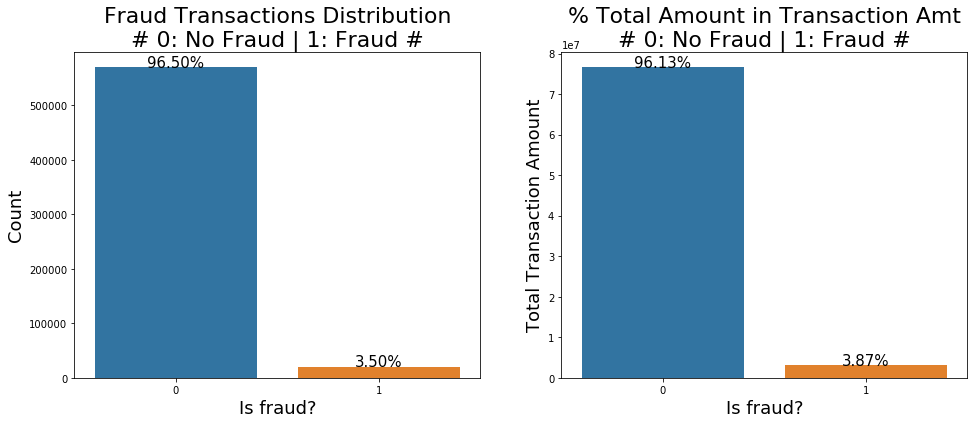

In [8]:
transaction_df['TransactionAmt'] = transaction_df['TransactionAmt'].astype(float)

plt.figure(figsize=(16, 6))

total_num_transactions = len(transaction_df)
total_transaction_amount = transaction_df.groupby(['isFraud'])['TransactionAmt'].sum().sum()

plt.subplot(121)

total_graph = sns.countplot(x='isFraud', data=transaction_df)
total_graph.set_title('Fraud Transactions Distribution\n# 0: No Fraud | 1: Fraud #', fontsize=22)

total_graph.set_xlabel('Is fraud?', fontsize=18)
total_graph.set_ylabel('Count', fontsize=18)

for patch in total_graph.patches:
    height = patch.get_height()
    total_graph.text(
        patch.get_x() + patch.get_width() / 2.0,
        height + 3,
        '{:1.2f}%'.format(height / total_num_transactions * 100),
        ha='center',
        fontsize=15
    )

percentage_transaction_amount = (transaction_df.groupby(['isFraud'])['TransactionAmt'].sum())
percentage_transaction_amount = percentage_transaction_amount.reset_index()

plt.subplot(122)

percentage_graph = sns.barplot(
    x='isFraud',
    y='TransactionAmt',
    dodge=True,
    data=percentage_transaction_amount
)

percentage_graph.set_title(
    '% Total Amount in Transaction Amt\n# 0: No Fraud | 1: Fraud #',
    fontsize=22
)

percentage_graph.set_xlabel('Is fraud?', fontsize=18)
percentage_graph.set_ylabel('Total Transaction Amount', fontsize=18)

for patch in percentage_graph.patches:
    height = patch.get_height()

    percentage_graph.text(
        patch.get_x() + patch.get_width() / 2.0,
        height + 3,
        '{:1.2f}%'.format(height / total_transaction_amount * 100),
        ha='center',
        fontsize=15
    )

plt.show()

### check transaction amount quantiles

In [9]:
transaction_df['TransactionAmt'] = transaction_df['TransactionAmt'].astype(float)

print('Transaction Amount Quantiles:')
print(transaction_df['TransactionAmt'].quantile([
    0.01,
    0.025,
    0.1,
    0.25,
    0.5,
    0.75,
    0.9,
    0.975,
    0.99,
]))

Transaction Amount Quantiles:
0.010       9.242188
0.025      14.500000
0.100      25.953125
0.250      43.312500
0.500      68.750000
0.750     125.000000
0.900     275.250000
0.975     648.262500
0.990    1104.000000
Name: TransactionAmt, dtype: float64


### TODO: plot transaction amount values distribution